# Estimating Energy Flux out of AR NOAA 1158

In [210]:
import numpy as np
from scipy.interpolate import interp1d
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import dask.array
import distributed
import h5py
from sunpy.instr.aia.response import Response
import sunpy.map

%matplotlib inline

In [36]:
client.close()

In [38]:
client = distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:44917 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


Using a Withbroe and Noyes (1978) value of $F=10^7$ erg cm$^{-2}$ s$^{-1}$ has proved too small in order to even *approximately* match the observed intensities and timelags. Instead, we'll use the observed AIA intensities in order to estimate the energy output of the AR and see if this gives a better result.

To do this, we'll average the observed intensities over a sufficiently long period, integrate over the whole AR, and then use the effective area and the gain to convert our observed intensities into a physically-meaningful quantity,

$$
I_c = \frac{1}{A_{eff,c}g_c}\frac{hc}{\lambda_c}\sum_{i_x,i_y}\sum_t\frac{\mathcal{p}(i_x,i_y,t)}{t_b - t_a}
$$

Then, sum over all wavelengths to get the total flux, $F^*$,

$$
F^* = \sum_cI_c
$$

This then serves as a lower bound for the losses of the AR.

In [103]:
r = Response()

In [128]:
wvl_response = r.calculate_wavelength_response()

In [155]:
wvl_response[94].response

<Quantity [  3.91648693e-11,  3.80516278e-11,  3.69713322e-11,...,
             1.01276680e-12,  1.00959399e-12,  1.00643419e-12] cm2 ct / ph>

In [167]:
wvl_response[94].response

<Quantity [  3.91648693e-11,  3.80516278e-11,  3.69713322e-11,...,
             1.01276680e-12,  1.00959399e-12,  1.00643419e-12] cm2 ct / ph>

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: divide by zero encountered in true_divide
  *arrays, **kwargs)


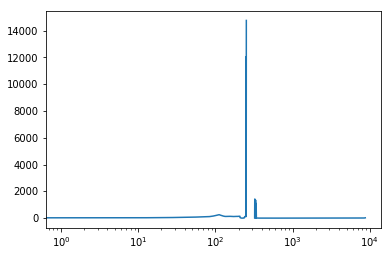

In [150]:
plt.plot(1./(wvl_response[94].response * 1*u.photon/((const.h * const.c).to(u.erg*u.angstrom)/wvl_response[94].wavelength)))
#plt.xlim(80,100)
#plt.ylim(0,100)
plt.xscale('log')

In [105]:
eff_area = {}
for c in wvl_response:
    eff_area[c] = r.calculate_effective_area(c)

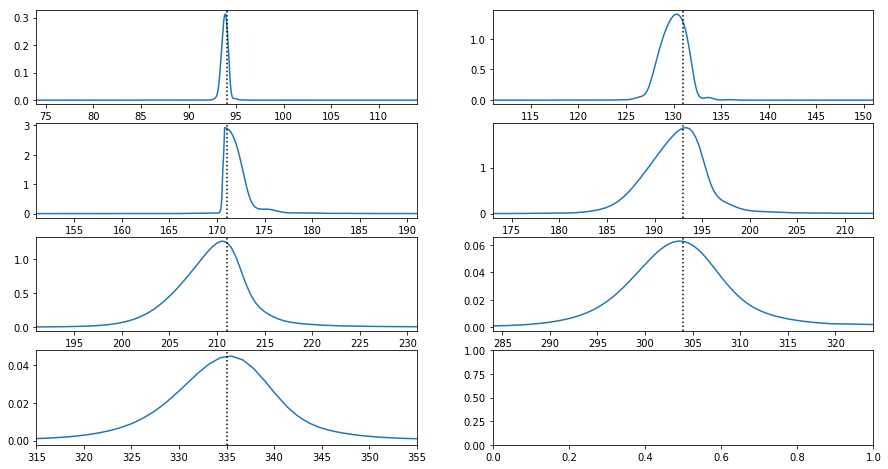

In [106]:
fig,axes = plt.subplots(4,2,figsize=(15,8))
for c,ax in zip(sorted(wvl_response.keys()),axes.flatten()):
    ax.plot(wvl_response[c].wavelength, eff_area[c])
    ax.set_xlim(c-20,c+20)
    ax.axvline(x=c,ls=':',color='k')

In [201]:
observed_intensity = {}
hf = h5py.File('observations/intensity_maps_observed.h5','r')
for c in [94,131,171,193,211,335]:
    # Get observed intensity, average and sum over area
    da = dask.array.from_array(hf[f'{c}']['data'], hf[f'{c}']['data'].chunks)
    I_c = da.sum(axis=2).compute() * u.count / u.pixel
    # Compute conversion factor for each channel
    conv = wvl_response[c].response / (const.h * const.c).to(u.erg*u.angstrom) * wvl_response[c].wavelength * u.photon
    conv = interp1d(wvl_response[c].wavelength, conv)(c) * conv.unit
    observed_intensity[c] = I_c / conv / r._channel_info[c]['plate_scale'] * (4. * np.pi * u.steradian)

In [224]:
t_obs = u.Quantity(hf['observing_time'],hf['observing_time'].attrs['units'])

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy-0.9.dev9659-py3.6-linux-x86_64.egg/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


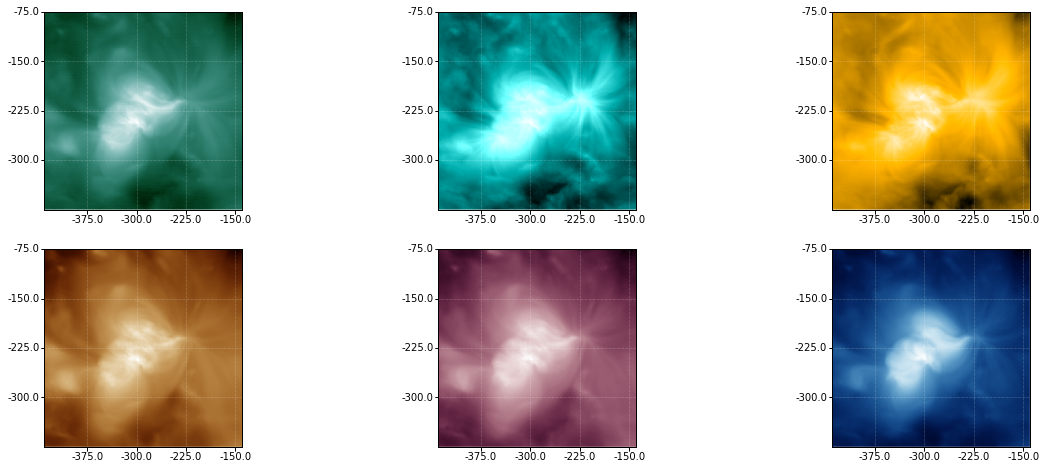

In [233]:
fig = plt.figure(figsize=(20,8))
for i,c in enumerate(observed_intensity):
    tmp_m = sunpy.map.Map(observed_intensity[c].value/(t_obs[-1] - t_obs[0]).value, dict(hf[f'{c}/meta'].attrs))
    ax = fig.add_subplot(2,3,i+1,projection=tmp_m)
    tmp_m.plot(axes=ax,annotate=False,title=False,
               #vmin=1e5,vmax=1e10
              )

In [227]:
total_flux = np.zeros(observed_intensity[c].shape) * observed_intensity[c].unit
for c in observed_intensity:
    total_flux += observed_intensity[c]
total_flux /= (t_obs[-1] - t_obs[0])

In [228]:
total_flux

<Quantity [[ 5546.94544781, 5524.80180258, 5508.18801519,...,
             8908.76327915, 8926.04296332, 8917.77596786],
           [ 5478.7487786 , 5469.44047536, 5445.18038576,...,
             8887.19680235, 8909.2195633 , 8912.22892933],
           [ 5376.97508567, 5363.27764078, 5369.6313733 ,...,
             8874.88731824, 8883.79278966, 8896.16580995],
           ..., 
           [ 4386.44271557, 4412.73844008, 4420.49916644,...,
             2732.97139252, 2752.84133903, 2770.55322659],
           [ 4358.15690122, 4387.49998842, 4401.51003172,...,
             2688.72105099, 2702.70283412, 2736.71606117],
           [ 4353.53061614, 4372.4376042 , 4400.75824882,...,
             2647.6726637 , 2658.02138036, 2698.90014009]] erg / (cm2 s)>

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy-0.9.dev9659-py3.6-linux-x86_64.egg/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


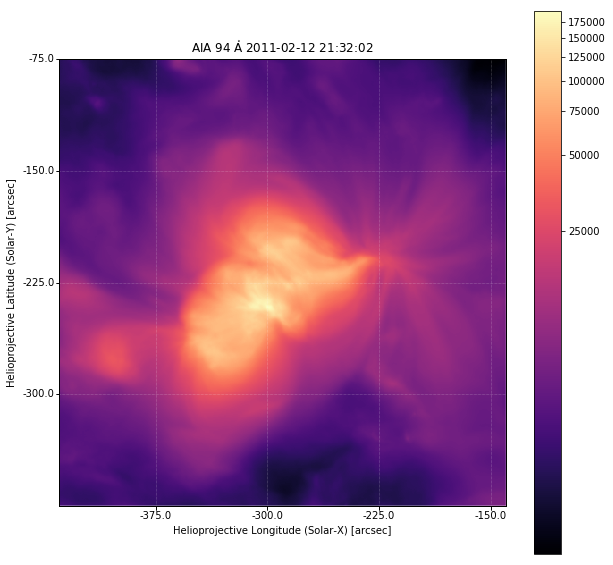

In [230]:
fig = plt.figure(figsize=(10,10))
flux_map = sunpy.map.Map(total_flux, dict(hf['94/meta'].attrs))
ax = fig.gca(projection=flux_map)
im = flux_map.plot(cmap='magma',axes=ax)
fig.colorbar(im)

In [232]:
flux_map.max()/1e7

0.019526127257571548